In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

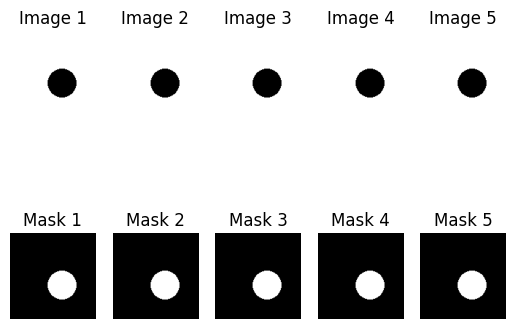

In [127]:
    
# Example function to generate synthetic images
data = []
masks = []
num_images = 5
image_size = 128

for _ in range(num_images):
    random.seed(777)
    
    # Generating a random shape on a contrasting background
    img = Image.new('RGB', (image_size, image_size), (255, 255, 255))  # White background
    draw_img = ImageDraw.Draw(img)
    
    mask = Image.new('L', (image_size, image_size), 0)  # Initialize mask
    draw_mask = ImageDraw.Draw(mask)
    
    # Adding a random shape (e.g., circle)
    shape_type = random.choice(['circle', 'square'])
    
    if shape_type == 'circle':
        center = (random.randint(20, image_size-20), random.randint(20, image_size-20))
        radius = random.randint(10, 30)
        
        draw_img.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius], fill=(0, 0, 0))  # Black circle
        draw_mask.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius], fill=255)  # White circle in the mask
    
    data.append(img)
    masks.append(mask)

# Displaying the generated images and masks
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(data[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Mask {i + 1}')

plt.show()

In [128]:
# Defining architecture
class arch(nn.Module):
    def __init__(self):
        super(arch, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)  # Change the output channels to 1 for binary segmentation
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

In [129]:

# creating different images to train

import random

class SyntheticDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return 100

    def __getitem__(self, idx):
        # Generate a synthetic image with a colored rectangle
        image = Image.new('RGB', (256, 256), (255, 255, 255))
        draw = ImageDraw.Draw(image)

        # Randomize the position of the rectangle
        x1 = random.randint(0, 200)
        y1 = random.randint(0, 200)
        x2 = random.randint(x1 + 50, 256)
        y2 = random.randint(y1 + 50, 256)

        # Randomly choose RGB colors
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        draw.rectangle([x1, y1, x2, y2], fill=color)  # Colored rectangle

        # Generate the corresponding binary mask
        mask = Image.new('L', (256, 256), 0)
        draw_mask = ImageDraw.Draw(mask)
        draw_mask.rectangle([x1, y1, x2, y2], fill=255)  # Mask for the rectangle

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



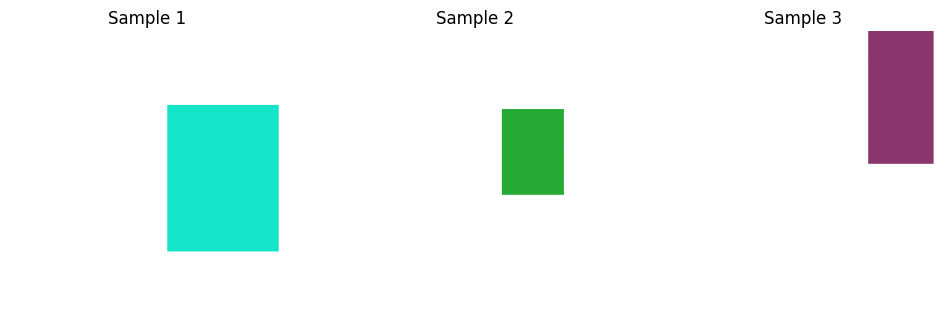

In [130]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create a synthetic dataset and dataloader
synthetic_dataset = SyntheticDataset(transform=transform)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=16, shuffle=True)
# image, mask = synthetic_dataset[700000]
# print(image, '\n')
# print(mask)

import matplotlib.pyplot as plt
import numpy as np

# Assuming `synthetic_dataset` is an instance of SyntheticDataset
num_samples_to_plot = 3

# Create a subplot for each sample
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(12, 4))

for i in range(num_samples_to_plot):
    # Get the i-th sample
    image, mask = synthetic_dataset[i]

    # Convert image from (3, 256, 256) to (256, 256, 3)
    image = np.transpose(image, (1, 2, 0))

    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(f'Sample {i + 1}')

    # Optionally, you can also plot the mask
    # axes[i].imshow(mask, cmap='gray', alpha=0.5)

    # Turn off axis labels
    axes[i].axis('off')

plt.show()



In [131]:
# Initialize the model, loss function, and optimizer
model = arch()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    for images, masks in synthetic_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/12, Loss: 0.32530707120895386
Epoch 2/12, Loss: 0.22486424446105957
Epoch 3/12, Loss: 0.06381543725728989
Epoch 4/12, Loss: 0.07481800764799118
Epoch 5/12, Loss: 0.011325364001095295
Epoch 6/12, Loss: 0.007847385480999947
Epoch 7/12, Loss: 0.03300749137997627
Epoch 8/12, Loss: 0.012769931927323341
Epoch 9/12, Loss: 0.018344201147556305
Epoch 10/12, Loss: 0.017287805676460266
Epoch 11/12, Loss: 0.009926688857376575
Epoch 12/12, Loss: 0.01766495779156685


In [132]:

# random.seed(11)
class testDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        # Generate a synthetic image with a colored rectangle
        imag = Image.new('RGB', (256, 256), (255, 255, 255))
        draw = ImageDraw.Draw(imag)
        # Randomizing the position of the rectangle for testing
        x1 = random.randint(0, 200)
        y1 = random.randint(0, 200)
        x2 = random.randint(x1 + 50, 256)
        y2 = random.randint(y1 + 50, 256)

        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        draw.rectangle([x1, y1, x2, y2], fill=color)  # Colored rectangle

        # Generate the corresponding binary mask
        mas = Image.new('L', (256, 256), 0)
        draw_mask = ImageDraw.Draw(mas)
        draw_mask.rectangle([x1, y1, x2, y2], fill=255)  # Mask for the rectangle

        if self.transform:
            imag = self.transform(imag)
            mas = self.transform(mas)

        return imag, mas

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create a synthetic dataset and dataloader
test_dataset = testDataset(transform=transform)
test_dataloader = DataLoader(ynthetic_dataset, batch_size=1, shuffle=True)

# Synthetic validation example
i, k = test_dataset[0]
model.eval()
with torch.no_grad():
    output = model(i.unsqueeze(0))  # Add an extra dimension for batch size
    prediction = torch.sigmoid(output) > 0.5
    

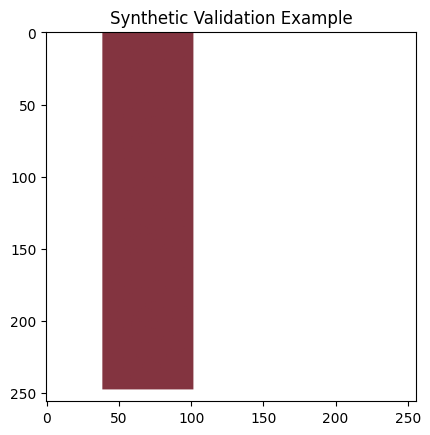

In [133]:

i = np.transpose(i, (1, 2, 0))
# Plot the image
plt.imshow(i)
plt.title('Synthetic Validation Example')
plt.show()


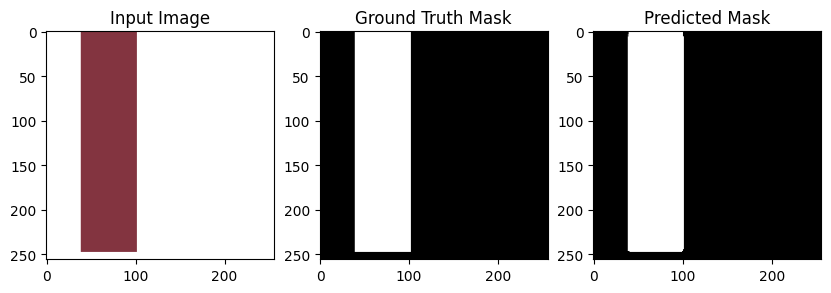

In [134]:
plt.figure(figsize=(10, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(TF.to_pil_image(i[0]))
plt.subplot(1, 3, 1)
plt.imshow(TF.to_pil_image(i.permute(2, 0, 1))) 
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(TF.to_pil_image(k[0]),cmap = 'gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(TF.to_pil_image(prediction[0].float()),cmap ='gray')  # Convert to float before visualization
plt.title("Predicted Mask")

plt.show()